In [1]:
!python -m spacy


ℹ Available commands
download, link, info, train, pretrain, debug-data, evaluate, convert, package,
init-model, profile, validate



# FourthBrain Week 10 - Applied Natural Language Processing

- **Goal:** This notebook will provide students with a deep dive into NLP starting with Text Classification where we will provide an overview of when to use count-based vs. sequence based NLP methods, discuss relevant deep learning architectures, as well as discuss model optimization/selection criteria, feature attritbution, and explainability. We will also include a brief overview of other common NLP tasks such as Named Entity Recognition (NER), Topic Modeling, and Key Phrase Extraction.

The IMDB movie reviews dataset contains 50,000 reviews — 25,000 positive and 25,000 negative reviews where the number of stars given by a user (out of 10) would be a good proxy for sentiment classification. 

For example, we could pre-assign the following:
- At least 7 out of 10 stars => positive (label=1)
- At most 4 out of 10 stars => negative (label=0)

In [2]:
import pandas as pd
pd.set_option('max_colwidth', 250)

imdb_df = pd.read_csv('https://github.com/Ankit152/IMDB-sentiment-analysis/blob/master/IMDB-Dataset.csv?raw=true')
print(imdb_df.shape)
imdb_df.head()

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes...",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well ch...",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the w...",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombi...",negative
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different...",positive


In [3]:
imdb_df.review.iloc[200]

"Interesting and short television movie describes some of the machinations surrounding Jay Leno's replacing Carson as host of the Tonight Show. Film is currently very topical given the public drama surrounding Conan O'Brien and Jay Leno.<br /><br />The film does a good job of sparking viewers' interest in the events and showing some of the concerns of the stakeholders, particularly of the NBC executives. The portrayal of Ovitz was particularly compelling and interesting, I thought.<br /><br />Still, many of the characters were only very briefly limned or touched upon, and some of the acting seemed perfunctory. Nevertheless, an interesting story."

In [4]:
imdb_df.sentiment.iloc[200]

'negative'

## Data Preprocessing

As with all machine learning problems, proper feature engineering can be the difference between a garbage-in-garbage-out model and one that can have significant business impact and NLP is no different. There are many different ways to improve the cleanliness of text features and below is a non-exhaustive list of pre-processing techniques:
- Convert to lower case ("Happy" -> "happy")
- Remove one character tokens (stray characters, accidental types, words like "a", etc.)
- Remove URLs (URLs are often one long string with no spaces so each unique URL would be considered a separate token)
- Replace multiple white spaces with one (" happy" -> "happy", general cleanliness as well as readability)
- Remove numbers (reduce dimensinality, "100" and "99" as strings are treated completely independently even though close in magnitude)
- Remove punctuation ("happy." -> "happy")
- Remove emails (reduce dimensionality)
- Remove new line char (readability and unnecessary token)
- Spelling correction ("hapy" -> "happy", can be slow and often unnecessary)
- Expand contractions ("can't" -> "can", "not")
- Remove stopwords (words like "the", "of", "and", etc.)
- Lemmatization (base form of a word using lookup dictionary, i.e. "pushing" -> "push")
- Stemming (base form of word using fixed rules, i.e. remove ing even in "spring" -> "spr")
- And more....

All of these techniques can be easily googled and implemented with re, NLTK, SpaCy, textblob, or other modules so we'll skip this and just define a simple function to preprocess the text with some of the above methods.

In [5]:
# Lower case
imdb_df['review_clean'] = imdb_df['review'].str.lower()

# Remove punctuation and numbers
imdb_df['review_clean'] = imdb_df['review_clean'].str.replace('[^\w\s]', ' ').str.replace('\d+', '')

# Remove extra space and short words
imdb_df['review_clean'] = imdb_df['review_clean'].apply(lambda x: ' '.join(x for x in x.split() if len(x) >= 2))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


In [6]:
# Inspect text before and after cleaning
imdb_df[['review', 'review_clean']].sample(5)

,review,review_clean
41481,NATIONAL LAMPOON'S CLASS REUNION was a flop when it was released. It didn't stay long in theaters in my big city. Why? Because it's BAD!!!!!<br /><br />Not bad in a good way but bad in a really painfully unfunny way. The entire cast of actors wer...,national lampoon class reunion was flop when it was released it didn stay long in theaters in my big city why because it bad br br not bad in good way but bad in really painfully unfunny way the entire cast of actors were mostly unknowns then and...
3700,"EA have shown us that they can make a classic 007 agent and make you feel in the 60's world. The graphics of the game are outstanding and also the voice recording is very professional. I got this game April 2007 (two years after release), and I a...",ea have shown us that they can make classic agent and make you feel in the world the graphics of the game are outstanding and also the voice recording is very professional got this game april two years after release and am still impressed with th...
24133,"This subject matter deserves a much better script, and final result, than this movie serves up. The script is full of holes because it was never conceived as a story, but rather a string of nightmare scenarios loosely knitted together. The gaps a...",this subject matter deserves much better script and final result than this movie serves up the script is full of holes because it was never conceived as story but rather string of nightmare scenarios loosely knitted together the gaps and loose en...
5827,"This is so blatantly a made-for-TV ripoff of Black Widow (1987) - even the insect titles are so similar.<br /><br />If you want a better ""marrying for money"" movie, check out Black Widow, starring Debra Winger & Theresa Russell.<br /><br />These ...",this is so blatantly made for tv ripoff of black widow even the insect titles are so similar br br if you want better marrying for money movie check out black widow starring debra winger theresa russell br br these movie is cheesiness at its best...
48950,"People who know me say I have a weakness for animated films.<br /><br />To be fair, those people are HALF right My actual weakness is for exceptionally well-done animated films, such as this vintage family flick from Max and David Fleischer.<br /...",people who know me say have weakness for animated films br br to be fair those people are half right my actual weakness is for exceptionally well done animated films such as this vintage family flick from max and david fleischer br br you may be ...


#### How to choose a text classification modeling approach?

Reference:  https://developers.google.com/machine-learning/guides/text-classification

At this point, we have assembled our dataset and gained insights into some of the key characteristics of our data. Next, we should think about which classification model we should use. This means asking questions such as:

- How do we present the text data to an algorithm that expects numeric input? (Data preprocessing and vectorization),
- What type of model should we use?
- What configuration parameters should we use for our model?, etc.

In the reference guide above, Google attempts to significantly simplify the process of selecting a text classification model. For a given dataset, the goal is to find the algorithm that achieves close to maximum accuracy while minimizing computation time required for training and experimentation. They ran a large number (~450K) of experiments across problems of different types (especially sentiment analysis and topic classification problems), using 12 datasets, alternating for each dataset between different data preprocessing techniques and different model architectures. This helped them identify dataset parameters that influence optimal choices.
The model selection algorithm and flowchart below is a summary of that experimentation.

In [7]:
imdb_df['num_words'] = imdb_df['review_clean'].apply(lambda x: len(x.split()))
print(imdb_df['num_words'].describe())
imdb_df.head()

count    50000.00000
mean       223.56912
std        167.12353
min          6.00000
25%        121.00000
50%        167.00000
75%        272.00000
max       2386.00000
Name: num_words, dtype: float64


,review,sentiment,review_clean,num_words
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes...",positive,one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violen...,307
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well ch...",positive,wonderful little production br br the filming technique is very unassuming very old time bbc fashion and gives comforting and sometimes discomforting sense of realism to the entire piece br br the actors are extremely well chosen michael sheen no...,160
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the w...",positive,thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread su...,158
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombi...",negative,basically there family where little boy jake thinks there zombie in his closet his parents are fighting all the time br br this movie is slower than soap opera and suddenly jake decides to become rambo and kill the zombie br br ok first of all wh...,125
4,"Petter Mattei's ""Love in the Time of Money"" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different...",positive,petter mattei love in the time of money is visually stunning film to watch mr mattei offers us vivid portrait about human relations this is movie that seems to be telling us what money power and success do to people in the different situations we...,227


In [8]:
import numpy as np

median_words_per_sample = np.median(imdb_df['num_words'])
sw_ratio = imdb_df.shape[0] / median_words_per_sample
print(f'Number of Samples / Number of Words per Sample Ratio: {int(sw_ratio)}')

Number of Samples / Number of Words per Sample Ratio: 299


<img src="https://developers.google.com/machine-learning/guides/text-classification/images/TextClassificationFlowchart.png" width=800>

Reference: https://developers.google.com/machine-learning/guides/text-classification/step-2-5

## Baseline Model for Text Classification

To speed up execution time we'll sample just 5,000 reviews

In [9]:
sample_df = imdb_df.sample(5000)
print(sample_df.shape)

(5000, 4)


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(imdb_df.review_clean, imdb_df.sentiment,
                                                    test_size=0.2,
                                                    stratify=imdb_df.sentiment,
                                                    random_state=42)
print(X_train.shape, X_test.shape)

(40000,) (10000,)


In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# Define the pipeline
tfidf = TfidfVectorizer(stop_words = 'english',
                        ngram_range = (1,3),
                        min_df = 10,
                        max_df = 0.5)

lr = LogisticRegression(C=10,
                        max_iter=1000,
                        random_state=42)

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', lr)
])

# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 23.5 s, sys: 4.24 s, total: 27.7 s
Wall time: 25.4 s


In [12]:
from sklearn.metrics import classification_report

y_test_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

    negative       0.92      0.90      0.91      5000
    positive       0.90      0.92      0.91      5000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [13]:
pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


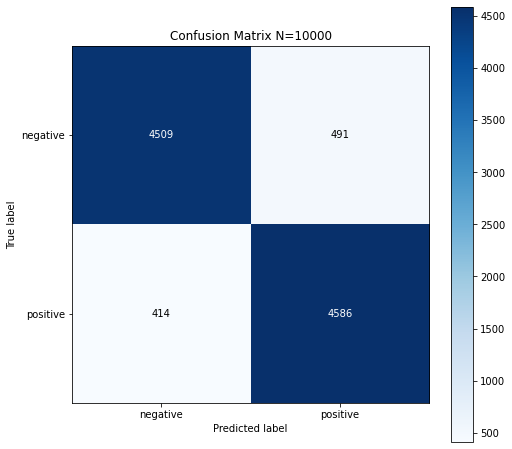

In [14]:
from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test, y_test_pred,
                      title=f'Confusion Matrix N={len(y_test)}',
                      figsize=(8,8));

## Feature Attribution and Explainability

In [15]:
pip install eli5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 4.3 MB/s 
     |████████████████████████████████| 133 kB 61.9 MB/s 
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107748 sha256=bc116591e672f9321442eb2b5612f2811d2feae887da990027964fbe113cbc64
  Stored in directory: /root/.cache/pip/wheels/cc/3c/96/3ead31a8e6c20fc0f1a707fde2e05d49a80b1b4b30096573be
Successfully built eli5
  Attempting uninstall: jinja2
    Found existing installation: Jinja2 2.11.3
    Uninstalling Jinja2-2.11.3:
      Successfully uninstalled Jinja2-2.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires Jinja2<3.0,>=2.10.1, but you have jinja2 3.1.2 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is inco

In [16]:
import eli5

# Get pipeline components for model and vectorizer
tfidf = pipeline.named_steps['tfidf']
clf = pipeline.named_steps['clf']

# Show top features
eli5.show_weights(clf, feature_names=tfidf.get_feature_names(), top=30)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Weight?,Feature
+12.141,excellent
+12.026,great
+10.208,perfect
+9.688,best
+9.486,amazing
+8.871,wonderful
+8.560,hilarious
+8.110,brilliant
+8.036,loved
+7.953,fun


In [17]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=af1636d30795e09a9887fe0f244a12fa679a2547cf784e84dbc76a5646eb9c90
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [18]:
from lime.lime_text import LimeTextExplainer

class_names = pipeline.classes_
explainer = LimeTextExplainer(class_names=class_names)

idx = 200
exp = explainer.explain_instance(imdb_df.review_clean.iloc[idx], pipeline.predict_proba, num_features=10)
print(f'Actual Label: {imdb_df.sentiment.iloc[idx]}')
exp.show_in_notebook()

Actual Label: negative


# Deep Learning based Text Classification

In [19]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [20]:
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

In [21]:
vocab_size = 5000
embedding_dim = 64
max_length = 300
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [23]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences,
                             maxlen=max_length,
                             padding=padding_type,
                             truncating=trunc_type)

print(f'Number of Training Sequences: {len(train_sequences)}')
print(f'Length of Training Sequence[0]: {len(train_sequences[0])}')
print(f'Length of Padded Training Sequence[0]: {len(train_padded[0])}')

Number of Training Sequences: 40000
Length of Training Sequence[0]: 154
Length of Padded Training Sequence[0]: 300


In [24]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences,
                            maxlen=max_length,
                            padding=padding_type,
                            truncating=trunc_type)

print(f'Number of Validation Sequences: {len(test_sequences)}')

Number of Validation Sequences: 10000


In [25]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False, dtype=np.int)
y_train_ohe = ohe.fit_transform(y_train.to_frame())
y_test_ohe = ohe.transform(y_test.to_frame())
print(f"Shape of training label tensor: {y_train_ohe.shape}")
print(f"Shape of testing label tensor: {y_test_ohe.shape}")
y_train_ohe[0,]

Shape of training label tensor: (40000, 2)
Shape of testing label tensor: (10000, 2)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


array([0, 1])

# Convolutional Neural Network (CNN)

 

Convolutional neural network architectures were designed to find spatial patterns in an image by sliding a small kernel window over an image. These windows are often small, perhaps 3x3 pixels in size, and each kernel cell has an associated weight. As a kernel slides over an image, pixel-by-pixel, the kernel weights are multiplied by the pixel value in the image underneath, then all the multiplied values are summed up to get an output, filtered pixel value.

 

In the case of text classification, a convolutional kernel will still be a sliding window, only its job is to look at embeddings for multiple words, rather than small areas of pixels in an image. The dimensions of the convolutional kernel will also have to change, according to this task. To look at sequences of word embeddings, we want a window to look at multiple word embeddings in a sequence. The kernels will no longer be square, instead, they will be a wide rectangle with dimensions like 3x300 or 5x300 (assuming an embedding length of 300). [Source and more detailed information on CNNs applied to Text Classification](https://cezannec.github.io/CNN_Text_Classification/)

 

![](https://cezannec.github.io/assets/cnn_text/complete_text_classification_CNN.png)

 

The above image was taken from the original [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882) paper (Yoon Kim).

In [26]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalAveragePooling1D, Dense

# Get number of classes from OneHotEncoder
num_classes = len(ohe.categories_[0])

In [27]:
# Define model architecture
cnn = tf.keras.Sequential([
    # The Embedding Layer provides a spatial mapping (or Word Embedding) of all the
    # individual words in our training set. Words close to one another share context
    # and or meaning. This spatial mapping is learned during the training process.
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

cnn.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 64)           320000    
                                                                 
 conv1d (Conv1D)             (None, 296, 32)           10272     
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 332,514
Trainable params: 332,514
Non-trainable params: 0
__________________________________________________

In [28]:
cnn_history = cnn.fit(train_padded, y_train_ohe,
                      epochs=10,
                      validation_data=(test_padded, y_test_ohe),
                      verbose=1)

Epoch 1/10
1250/1250 [==============================] - 20s 4ms/step - loss: 0.3421 - accuracy: 0.8485 - val_loss: 0.2714 - val_accuracy: 0.8870
Epoch 2/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2355 - accuracy: 0.9056 - val_loss: 0.2652 - val_accuracy: 0.8876
Epoch 3/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.2099 - accuracy: 0.9177 - val_loss: 0.2688 - val_accuracy: 0.8856
Epoch 4/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1897 - accuracy: 0.9282 - val_loss: 0.2794 - val_accuracy: 0.8856
Epoch 5/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1734 - accuracy: 0.9362 - val_loss: 0.3020 - val_accuracy: 0.8847
Epoch 6/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1568 - accuracy: 0.9430 - val_loss: 0.3061 - val_accuracy: 0.8830
Epoch 7/10
1250/1250 [==============================] - 5s 4ms/step - loss: 0.1362 - accuracy: 0.9535 - val_loss: 0.3185 - val_accuracy

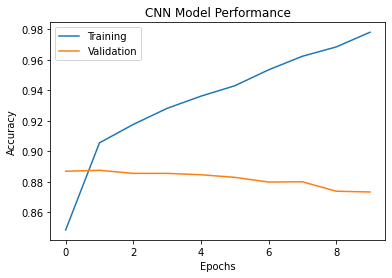

In [29]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('CNN Model Performance')
plt.show()

In [30]:
from sklearn.metrics import classification_report, accuracy_score

y_test_pred_probs = cnn.predict(test_padded)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(classification_report(np.argmax(y_test_ohe, axis=1), np.argmax(y_test_pred_probs, axis=1), target_names=ohe.categories_[0].tolist()))

              precision    recall  f1-score   support

    negative       0.89      0.86      0.87      5000
    positive       0.86      0.89      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



# Parallel CNN with Varying Kernel/Filter Sizes

In [31]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, SpatialDropout1D, GlobalMaxPooling1D, concatenate, Dropout

def create_network(num_classes, max_length, drop_embed = 0.2,
                   n_conv_1 = 256,  n_conv_2 = 256,  n_conv_3 = 256,
                   k_conv_1 = 3, k_conv_2 = 4, k_conv_3 = 6,
                   n_dense = 512, dropout = 0.2, optimizer = "adam"):

    input_layer = Input(shape=(max_length,), dtype='int32', name='input')
    embedding_layer = Embedding(vocab_size, embedding_dim, input_length=max_length)(input_layer)
    drop_embed_layer = SpatialDropout1D(drop_embed, name='drop_embed')(embedding_layer)
    conv_1 = Conv1D(n_conv_1, k_conv_1, activation='relu', name='conv_1')(drop_embed_layer)
    maxp_1 = GlobalMaxPooling1D(name='maxp_1')(conv_1)
    conv_2 = Conv1D(n_conv_2, k_conv_2, activation='relu', name='conv_2')(drop_embed_layer)
    maxp_2 = GlobalMaxPooling1D(name='maxp_2')(conv_2)
    conv_3 = Conv1D(n_conv_3, k_conv_3, activation='relu', name='conv_3')(drop_embed_layer)
    maxp_3 = GlobalMaxPooling1D(name='maxp_3')(conv_3)
    concat = concatenate([maxp_1, maxp_2, maxp_3])
    dense_layer = Dense(n_dense, activation='relu', name='dense')(concat)
    drop_dense_layer = Dropout(dropout, name='drop_dense')(dense_layer)
    predictions = Dense(num_classes, activation='softmax', name='output')(drop_dense_layer)

    model = Model(input_layer, predictions)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

    return model

In [32]:
parallel_cnn = create_network(num_classes, max_length, drop_embed = 0.1,
                              n_conv_1 = 512,  n_conv_2 = 512,  n_conv_3 = 512,
                              k_conv_1 = 3, k_conv_2 = 4, k_conv_3 = 10,
                              n_dense = 512, dropout = 0.2, optimizer = "adam")

parallel_cnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 300, 64)      320000      ['input[0][0]']                  
                                                                                                  
 drop_embed (SpatialDropout1D)  (None, 300, 64)      0           ['embedding_1[0][0]']            
                                                                                                  
 conv_1 (Conv1D)                (None, 298, 512)     98816       ['drop_embed[0][0]']             
                                                                                              

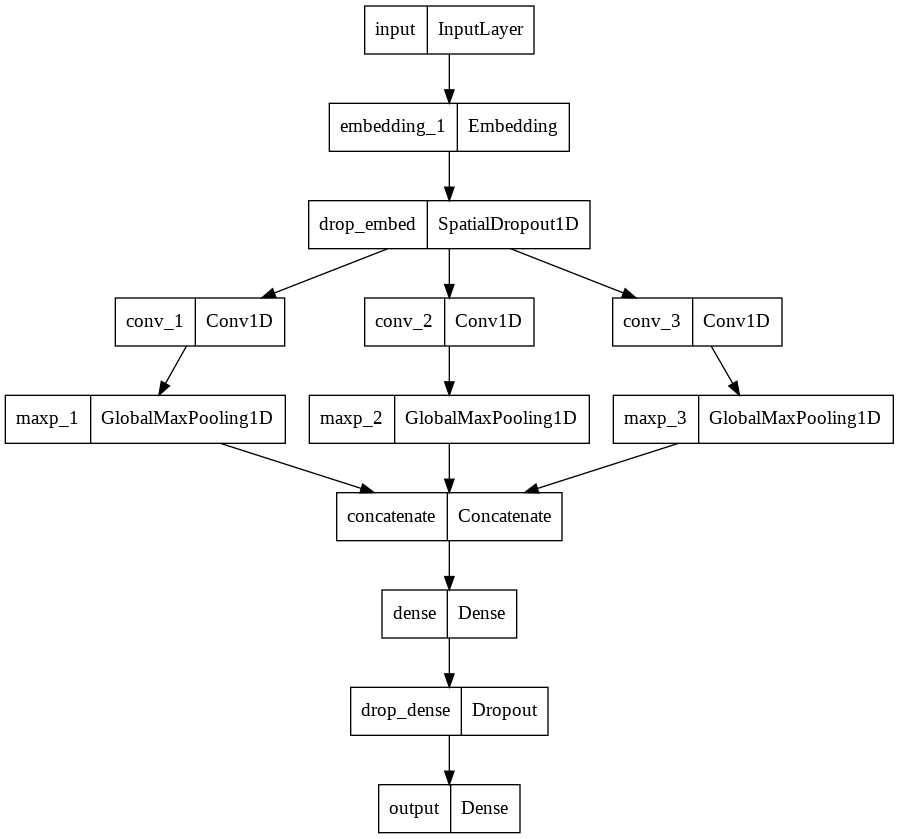

In [33]:
from tensorflow.keras.utils import plot_model

plot_model(parallel_cnn)

In [34]:
parallel_cnn_history = parallel_cnn.fit(train_padded, y_train_ohe,
                                        epochs=10,
                                        validation_data=(test_padded, y_test_ohe),
                                        verbose=1)

Epoch 1/10
1250/1250 [==============================] - 21s 16ms/step - loss: 0.3421 - accuracy: 0.8430 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2945 - val_accuracy: 0.8712 - val_top_k_categorical_accuracy: 1.0000
Epoch 2/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.2119 - accuracy: 0.9178 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2531 - val_accuracy: 0.8922 - val_top_k_categorical_accuracy: 1.0000
Epoch 3/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.1392 - accuracy: 0.9495 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.2773 - val_accuracy: 0.8977 - val_top_k_categorical_accuracy: 1.0000
Epoch 4/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0779 - accuracy: 0.9733 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.3489 - val_accuracy: 0.8924 - val_top_k_categorical_accuracy: 1.0000
Epoch 5/10
1250/1250 [==============================] - 21s 17ms/step - loss: 0.0430 - accuracy: 0.9841 

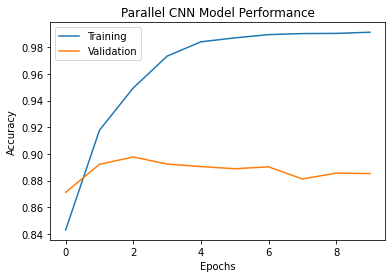

In [35]:
import matplotlib.pyplot as plt

plt.plot(parallel_cnn_history.history['accuracy'])
plt.plot(parallel_cnn_history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Parallel CNN Model Performance')
plt.show()

In [36]:
from sklearn.metrics import classification_report, accuracy_score

y_test_pred_probs = parallel_cnn.predict(test_padded)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(classification_report(np.argmax(y_test_ohe, axis=1), np.argmax(y_test_pred_probs, axis=1), target_names=ohe.categories_[0].tolist()))

              precision    recall  f1-score   support

    negative       0.86      0.91      0.89      5000
    positive       0.91      0.86      0.88      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



## 4.3 Long Short-Term Memory (LSTM) Network

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work.1 They work tremendously well on a large variety of problems, and are now widely used.

For a step-by-step walkthrough of the LSTM architecture, I highly recommend this article/video: [Illustrated Guide to LSTMs and GRUs](https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21)

![](https://wiki.tum.de/download/attachments/22578349/GATES.gif?version=1&modificationDate=1486083227237&api=v2)

In [37]:
from tensorflow.keras.layers import Dropout, LSTM, Bidirectional

lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    LSTM(128),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

lstm.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 64)           320000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense_2 (Dense)             (None, 32)                4128      
                                                                 
 dense_3 (Dense)             (None, 2)                 66        
                                                                 
Total params: 423,010
Trainable params: 423,010
Non-trainable params: 0
_________________________________________________________________


In [38]:
lstm_history = lstm.fit(train_padded, y_train_ohe,
                        epochs=10,
                        validation_data=(test_padded, y_test_ohe),
                        verbose=2)

Epoch 1/10
1250/1250 - 24s - loss: 0.6830 - accuracy: 0.5370 - val_loss: 0.6768 - val_accuracy: 0.5694 - 24s/epoch - 19ms/step
Epoch 2/10
1250/1250 - 21s - loss: 0.6758 - accuracy: 0.5796 - val_loss: 0.6777 - val_accuracy: 0.5874 - 21s/epoch - 17ms/step
Epoch 3/10
1250/1250 - 21s - loss: 0.6706 - accuracy: 0.5974 - val_loss: 0.6722 - val_accuracy: 0.5904 - 21s/epoch - 17ms/step
Epoch 4/10
1250/1250 - 21s - loss: 0.6745 - accuracy: 0.5574 - val_loss: 0.6806 - val_accuracy: 0.5591 - 21s/epoch - 17ms/step
Epoch 5/10
1250/1250 - 21s - loss: 0.6452 - accuracy: 0.6205 - val_loss: 0.6591 - val_accuracy: 0.6110 - 21s/epoch - 17ms/step
Epoch 6/10
1250/1250 - 22s - loss: 0.6565 - accuracy: 0.6155 - val_loss: 0.5810 - val_accuracy: 0.7245 - 22s/epoch - 17ms/step
Epoch 7/10
1250/1250 - 21s - loss: 0.3620 - accuracy: 0.8403 - val_loss: 0.3506 - val_accuracy: 0.8331 - 21s/epoch - 17ms/step
Epoch 8/10
1250/1250 - 22s - loss: 0.3182 - accuracy: 0.8457 - val_loss: 0.5564 - val_accuracy: 0.6603 - 22s/ep

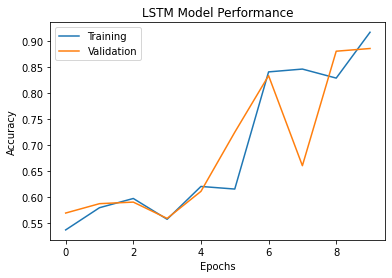

In [39]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('LSTM Model Performance')
plt.show()

In [40]:
from sklearn.metrics import classification_report, accuracy_score

y_test_pred_probs = lstm.predict(test_padded)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(classification_report(np.argmax(y_test_ohe, axis=1), np.argmax(y_test_pred_probs, axis=1), target_names=ohe.categories_[0].tolist()))

              precision    recall  f1-score   support

    negative       0.91      0.85      0.88      5000
    positive       0.86      0.92      0.89      5000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [41]:
bi_lstm = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(128)),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax')
])

bi_lstm.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
bi_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 64)           320000    
                                                                 
 bidirectional (Bidirectiona  (None, 256)              197632    
 l)                                                              
                                                                 
 dense_4 (Dense)             (None, 32)                8224      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 525,922
Trainable params: 525,922
Non-trainable params: 0
_________________________________________________________________


In [42]:
bi_lstm_history = bi_lstm.fit(train_padded, y_train_ohe,
                              epochs=10,
                              validation_data=(test_padded, y_test_ohe),
                              verbose=2)

Epoch 1/10
1250/1250 - 43s - loss: 0.5335 - accuracy: 0.7331 - val_loss: 0.6768 - val_accuracy: 0.5587 - 43s/epoch - 35ms/step
Epoch 2/10
1250/1250 - 40s - loss: 0.5411 - accuracy: 0.7365 - val_loss: 0.5210 - val_accuracy: 0.8076 - 40s/epoch - 32ms/step
Epoch 3/10
1250/1250 - 40s - loss: 0.3617 - accuracy: 0.8530 - val_loss: 0.3430 - val_accuracy: 0.8644 - 40s/epoch - 32ms/step
Epoch 4/10
1250/1250 - 40s - loss: 0.2986 - accuracy: 0.8794 - val_loss: 0.3199 - val_accuracy: 0.8715 - 40s/epoch - 32ms/step
Epoch 5/10
1250/1250 - 40s - loss: 0.2517 - accuracy: 0.9013 - val_loss: 0.2783 - val_accuracy: 0.8861 - 40s/epoch - 32ms/step
Epoch 6/10
1250/1250 - 40s - loss: 0.2143 - accuracy: 0.9172 - val_loss: 0.2880 - val_accuracy: 0.8878 - 40s/epoch - 32ms/step
Epoch 7/10
1250/1250 - 41s - loss: 0.1953 - accuracy: 0.9247 - val_loss: 0.2765 - val_accuracy: 0.8875 - 41s/epoch - 32ms/step
Epoch 8/10
1250/1250 - 40s - loss: 0.1579 - accuracy: 0.9434 - val_loss: 0.3111 - val_accuracy: 0.8869 - 40s/ep

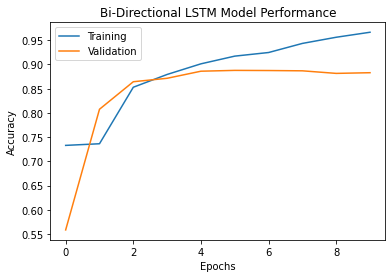

In [43]:
import matplotlib.pyplot as plt

plt.plot(bi_lstm_history.history['accuracy'])
plt.plot(bi_lstm_history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])
plt.title('Bi-Directional LSTM Model Performance')
plt.show()

In [44]:
from sklearn.metrics import classification_report, accuracy_score

y_test_pred_probs = bi_lstm.predict(test_padded)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
print(classification_report(np.argmax(y_test_ohe, axis=1), np.argmax(y_test_pred_probs, axis=1), target_names=ohe.categories_[0].tolist()))

              precision    recall  f1-score   support

    negative       0.88      0.89      0.88      5000
    positive       0.89      0.87      0.88      5000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



# Topic Modeling

![](https://miro.medium.com/max/780/0*eTImSma37fd3aPka.png)

### The two main inputs to the `gensim` LDA topic model are the dictionary `id2word` and the `corpus`.
- `id2word` is a special object created by `gensim` that keeps track of the mapping from text to numerical index, and the mapping from numerical index back to text
- The `corpus` is a specially formatted list containing information about each document. Though its format is different, is essentially equivalent to the document-term matrix that we used with `sklearn`

In [45]:
imdb_df.head(2)

,review,sentiment,review_clean,num_words
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes...",positive,one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violen...,307
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well ch...",positive,wonderful little production br br the filming technique is very unassuming very old time bbc fashion and gives comforting and sometimes discomforting sense of realism to the entire piece br br the actors are extremely well chosen michael sheen no...,160


## Let's start with a quick SpaCy 101 Tutorial

Adapted from this Kaggle Kernel: https://www.kaggle.com/code/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook 

In [46]:
import spacy

# load in our spaCy language model
spacy.cli.download("en_core_web_md")
nlp = spacy.load("en_core_web_md")

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


![](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/SpaCy_logo.svg/1200px-SpaCy_logo.svg.png)<a id="TOC2"></a> <br>

## Table of Contents
1. [**What is spaCy**](#1)

    1.1 [**What spaCy is NOT**](#11)
    
    1.2 [**Installation**](#12)
    
    1.3 [**Statistical Models**](#13)
    
    1.4 [**Dependency Parsing**](#14)
    
    1.5 [**spaCy’s Processing Pipeline**](#15)
        
1. [**Features**](#2)
    
    2.1 [**Tokenization**](#21)
    
    2.2 [**Part-Of-Speech (POS) Tagging**](#22)
    
    2.3 [**Dependency Parsing**](#23)
    
    2.4 [**Lemmatization**](#24)
    
    2.5 [**Sentence Boundary Detection (SBD)**](#25)
    
    2.6 [**Named Entity Recognition (NER)**](#26)
    
    2.7 [**Entity Linking (EL)**](#27)
    
    2.8 [**Similarity**](#28)

## 1. What is spaCy <a id="1"></a> <br>
    
spaCy is a free, open-source library for advanced Natural Language Processing (NLP) in Python. It’s written in Cython and is designed to build information extraction or natural language understanding systems. It’s built for production use and provides a concise and user-friendly API.

If you’re working with a lot of text, you’ll eventually want to know more about it. For example, what’s it about? What do the words mean in context? Who is doing what to whom? What companies and products are mentioned? Which texts are similar to each other?

spaCy is designed specifically for production use and helps you build applications that process and “understand” large volumes of text. It can be used to build information extraction or natural language understanding systems, or to pre-process text for deep learning.

### 1.1 What spaCy is NOT <a id="11"></a> <br>

* **spaCy is not a platform** or “an API”. Unlike a platform, spaCy does not provide a software as a service, or a web application. It’s an open-source library designed to help you build NLP applications, not a consumable service.

* **spaCy is not an out-of-the-box chat bot engine**. While spaCy can be used to power conversational applications, it’s not designed specifically for chat bots, and only provides the underlying text processing capabilities.

* **spaCy is not research software**. It’s built on the latest research, but it’s designed to get things done. This leads to fairly different design decisions than NLTK or CoreNLP, which were created as platforms for teaching and research. The main difference is that spaCy is integrated and opinionated. spaCy tries to avoid asking the user to choose between multiple algorithms that deliver equivalent functionality. Keeping the menu small lets spaCy deliver generally better performance and developer experience.

* **spaCy is not a company.** It’s an open-source library. Our company publishing spaCy and other software is called Explosion AI.



### 1.3 Statistical models <a id="13"></a> <br>

Some of spaCy’s features work independently, others require statistical models to be loaded, which enable spaCy to predict linguistic annotations – for example, whether a word is a verb or a noun. spaCy currently offers statistical models for a variety of languages, which can be installed as individual Python modules. Models can differ in size, speed, memory usage, accuracy and the data they include. The model you choose always depends on your use case and the texts you’re working with. For a general-purpose use case, the small, default models are always a good start. They typically include the following components:

* **Binary weights** for the part-of-speech tagger, dependency parser and named entity recognizer to predict those annotations in context.
* **Lexical entries** in the vocabulary, i.e. words and their context-independent attributes like the shape or spelling.
* **Data files** like lemmatization rules and lookup tables.
* **Word vectors**, i.e. multi-dimensional meaning representations of words that let you determine how similar they are to each other.
* **Configuration** options, like the language and processing pipeline settings, to put spaCy in the correct state when you load in the model.

These models are the power engines of spaCy. These models enable spaCy to perform several NLP related tasks, such as part-of-speech tagging, named entity recognition, and dependency parsing.

I’ve listed below the different statistical models in spaCy along with their specifications:

* en_core_web_sm: English multi-task CNN trained on OntoNotes. Size – 11 MB

* en_core_web_md: English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Size – 91 MB

* en_core_web_lg: English multi-task CNN trained on OntoNotes, with GloVe vectors trained on Common Crawl. Size – 789 MB

Importing these models is super easy. We can import a model by just executing spacy.load(‘model_name’) as shown below:


### 1.4 Linguistic annotations <a id="14"></a> <br>


spaCy provides a variety of linguistic annotations to give you insights into a text’s grammatical structure. This includes the word types, like the parts of speech, and how the words are related to each other. For example, if you’re analyzing text, it makes a huge difference whether a noun is the subject of a sentence, or the object – or whether “google” is used as a verb, or refers to the website or company in a specific context.

Once you have downloaded and installed a model, you can load it via spacy.load(). This will return a Language object containing all components and data needed to process text. We usually call it nlp. Calling the nlp object on a string of text will return a processed Doc:

In [47]:
doc = nlp("Company Y is planning to acquire stake in X company for $23 billion")
for token in doc:
    print(token.text, token.pos_, token.dep_)

Company NOUN compound
Y PROPN nsubj
is AUX aux
planning VERB ROOT
to PART aux
acquire VERB xcomp
stake NOUN dobj
in ADP prep
X PROPN compound
company NOUN pobj
for ADP prep
$ SYM quantmod
23 NUM compound
billion NUM pobj


Even though a Doc is processed – e.g. split into individual words and annotated – it still holds all information of the original text, like whitespace characters. You can always get the offset of a token into the original string, or reconstruct the original by joining the tokens and their trailing whitespace. This way, you’ll never lose any information when processing text with spaCy.

spaCy’s Processing Pipeline
### 1.5 spaCy’s Processing Pipeline <a id="15"></a> <br>
The first step for a text string, when working with spaCy, is to pass it to an NLP object. This object is essentially a pipeline of several text pre-processing operations through which the input text string has to go through.

![](https://d33wubrfki0l68.cloudfront.net/16b2ccafeefd6d547171afa23f9ac62f159e353d/48b91/pipeline-7a14d4edd18f3edfee8f34393bff2992.svg)

As you can see in the figure above, the NLP pipeline has multiple components, such as tokenizer, tagger, parser, ner, etc. So, the input text string has to go through all these components before we can work on it.

Let me show you how we can create an nlp object:



In [48]:
# Create an nlp object
doc = nlp("He went to play cricket with friends in the stadium")

You can use the below code to figure out the active pipeline components:

In [49]:
nlp.pipe_names

['tagger', 'parser', 'ner']

Just in case you wish to disable the pipeline components and keep only the tokenizer up and running, then you can use the code below to disable the pipeline components:

In [50]:
nlp.disable_pipes('tagger', 'parser')

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7f561f6f3fd0>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f562df99c20>)]

Let’s again check the active pipeline component:

In [51]:
nlp.pipe_names

['ner']

In [52]:
# Re-load in our spaCy object
nlp = spacy.load("en_core_web_md")

## 2. Features <a id="2"></a> <br>
### 2.1 Tokenization <a id="21"></a> <br>

	Segmenting text into words, punctuations marks etc.

During processing, spaCy first tokenizes the text, i.e. segments it into words, punctuation and so on. This is done by applying rules specific to each language.

In [53]:
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
for token in doc:
    print(token.text)

Reliance
is
looking
at
buying
U.K.
based
analytics
startup
for
$
7
billion


First, the raw text is split on whitespace characters, similar to text.split(' '). Then, the tokenizer processes the text from left to right. On each substring, it performs two checks:

* Does the substring match a tokenizer exception rule? For example, “don’t” does not contain whitespace, but should be split into two tokens, “do” and “n’t”, while “U.K.” should always remain one token.

* Can a prefix, suffix or infix be split off? For example punctuation like commas, periods, hyphens or quotes.

If there’s a match, the rule is applied and the tokenizer continues its loop, starting with the newly split substrings. This way, spaCy can split complex, nested tokens like combinations of abbreviations and multiple punctuation marks.

![](https://d33wubrfki0l68.cloudfront.net/fedbc2aef51d678ae40a03cb35253dae2d52b18b/3d4b2/tokenization-57e618bd79d933c4ccd308b5739062d6.svg)

### 2.2 Part-Of-Speech (POS) Tagging <a id="22"></a> <br>

Part of speech or POS is a grammatical role that explains how a particular word is used in a sentence. There are eight parts of speech.

* Noun
* Pronoun
* Adjective
* Verb
* Adverb
* Preposition
* Conjunction
* Interjection

Part of speech tagging is the process of assigning a POS tag to each token depending on its usage in the sentence. POS tags are useful for assigning a syntactic category like noun or verb to each word.

After tokenization, spaCy can parse and tag a given Doc. This is where the statistical model comes in, which enables spaCy to make a prediction of which tag or label most likely applies in this context. A model consists of binary data and is produced by showing a system enough examples for it to make predictions that generalize across the language – for example, a word following “the” in English is most likely a noun.

Linguistic annotations are available as Token attributes. Like many NLP libraries, spaCy encodes all strings to hash values to reduce memory usage and improve efficiency. So to get the readable string representation of an attribute, we need to add an underscore _ to its name.

In English grammar, the parts of speech tell us what is the function of a word and how it is used in a sentence. Some of the common parts of speech in English are Noun, Pronoun, Adjective, Verb, Adverb, etc.

POS tagging is the task of automatically assigning POS tags to all the words of a sentence. It is helpful in various downstream tasks in NLP, such as feature engineering, language understanding, and information extraction.

Performing POS tagging, in spaCy, is a cakewalk.

In spaCy, POS tags are available as an attribute on the Token object:

In [54]:
# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token, token.tag_, token.pos_, spacy.explain(token.tag_))

Reliance NN NOUN noun, singular or mass
is VBZ AUX verb, 3rd person singular present
looking VBG VERB verb, gerund or present participle
at IN ADP conjunction, subordinating or preposition
buying VBG VERB verb, gerund or present participle
U.K. NNP PROPN noun, proper singular
based VBN VERB verb, past participle
analytics NNS NOUN noun, plural
startup NN NOUN noun, singular or mass
for IN ADP conjunction, subordinating or preposition
$ $ SYM symbol, currency
7 CD NUM cardinal number
billion CD NUM cardinal number


Using spaCy’s built-in **displaCy** visualizer,The quickest way to visualize Doc is to use displacy.serve. This will spin up a simple web server and let you view the result straight from your browser. displaCy can either take a single Doc or a list of Doc objects as its first argument. This lets you construct them however you like – using any model or modifications you like.Here’s what our example sentence and its dependencies look like:

In [55]:
import spacy
from spacy import displacy

doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
displacy.render(doc, style="dep" , jupyter=True)

### 2.3 Dependency Parsing <a id="23"></a> <br>

Dependency parsing is the process of extracting the dependency parse of a sentence to represent its grammatical structure. It defines the dependency relationship between headwords and their dependents. The head of a sentence has no dependency and is called the root of the sentence. The verb is usually the head of the sentence. All other words are linked to the headword.

The dependencies can be mapped in a directed graph representation:

* Words are the nodes.
* The grammatical relationships are the edges.

Dependency parsing helps you know what role a word plays in the text and how different words relate to each other. It’s also used in shallow parsing and named entity recognition.

Here’s how you can use dependency parsing to see the relationships between words:
![](https://www.researchgate.net/profile/Michael_Ringgaard/publication/220816955/figure/fig2/AS:667852638019597@1536239885253/Dependency-Parse-Tree-with-Alignment-for-a-Sentence-with-Preposition-Modifier.png)
Performing dependency parsing is again pretty easy in spaCy. We will use the same sentence here that we used for POS tagging:

In [56]:
# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.dep_)

Reliance --> nsubj
is --> aux
looking --> ROOT
at --> prep
buying --> pcomp
U.K. --> nmod
based --> amod
analytics --> compound
startup --> dobj
for --> prep
$ --> quantmod
7 --> compound
billion --> pobj


### 2.4 Lemmatization <a id="24"></a> <br>

**Lemmatization** is the process of reducing inflected forms of a word while still ensuring that the reduced form belongs to the language. This reduced form or root word is called a lemma.

For example, organizes, organized and organizing are all forms of organize. Here, organize is the lemma. The inflection of a word allows you to express different grammatical categories like tense (organized vs organize), number (trains vs train), and so on. Lemmatization is necessary because it helps you reduce the inflected forms of a word so that they can be analyzed as a single item. It can also help you normalize the text.

spaCy has the attribute lemma_ on the Token class. This attribute has the lemmatized form of a token:

In [57]:
# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")
 
# Iterate over the tokens
for token in doc:
    # Print the token and its part-of-speech tag
    print(token.text, "-->", token.lemma_)

Reliance --> reliance
is --> be
looking --> look
at --> at
buying --> buy
U.K. --> U.K.
based --> base
analytics --> analytic
startup --> startup
for --> for
$ --> $
7 --> 7
billion --> billion


### 2.5 Sentence Boundary Detection (SBD) <a id="25"></a> <br>

**Sentence Boundary Detection** is the process of locating the start and end of sentences in a given text. This allows you to you divide a text into linguistically meaningful units. You’ll use these units when you’re processing your text to perform tasks such as part of speech tagging and entity extraction.

In spaCy, the sents property is used to extract sentences. Here’s how you would extract the total number of sentences and the sentences for a given input text:


In [58]:
# Create an nlp object
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion.This is India.India is great")
 
sentences = list(doc.sents)
len(sentences)

3

In [59]:
for sentence in sentences:
     print (sentence)

Reliance is looking at buying U.K. based analytics startup for $7 billion.
This is India.
India is great


### 2.6 Named Entity Recognition (NER) <a id="26"></a> <br>

A named entity is a “real-world object” that’s assigned a name – for example, a person, a country, a product or a book title. spaCy can recognize various types of named entities in a document, by asking the model for a prediction. Because models are statistical and strongly depend on the examples they were trained on, this doesn’t always work perfectly and might need some tuning later, depending on your use case.

Named entities are available as the ents property of a Doc:

In [60]:
doc = nlp("Reliance is looking at buying U.K. based analytics startup for $7 billion")

for ent in doc.ents:
    print(ent.text, ent.start_char, ent.end_char, ent.label_)

Reliance 0 8 ORG
U.K. 30 34 GPE
$7 billion 63 73 MONEY


### 2.7 Entity Detection <a id="27"></a> <br>

**Entity detection**, also called entity recognition, is a more advanced form of language processing that identifies important elements like places, people, organizations, and languages within an input string of text. This is really helpful for quickly extracting information from text, since you can quickly pick out important topics or indentify key sections of text.

Let’s try out some entity detection using a few paragraphs from this recent article in the Washington Post. We’ll use .label to grab a label for each entity that’s detected in the text, and then we’ll take a look at these entities in a more visual format using spaCy‘s displaCy visualizer.

In [61]:
import spacy
from spacy import displacy

doc= nlp(u"""The Amazon rainforest,[a] alternatively, the Amazon Jungle, also known in English as Amazonia, is a moist broadleaf tropical rainforest in the Amazon biome that covers most of the Amazon basin of South America. This basin encompasses 7,000,000 km2 (2,700,000 sq mi), of which 5,500,000 km2 (2,100,000 sq mi) are covered by the rainforest. This region includes territory belonging to nine nations.

The majority of the forest is contained within Brazil, with 60% of the rainforest, followed by Peru with 13%, Colombia with 10%, and with minor amounts in Bolivia, Ecuador, French Guiana, Guyana, Suriname, and Venezuela. Four nations have "Amazonas" as the name of one of their first-level administrative regions and France uses the name "Guiana Amazonian Park" for its rainforest protected area. The Amazon represents over half of the planet's remaining rainforests,[2] and comprises the largest and most biodiverse tract of tropical rainforest in the world, with an estimated 390 billion individual trees divided into 16,000 species.[3]

Etymology
The name Amazon is said to arise from a war Francisco de Orellana fought with the Tapuyas and other tribes. The women of the tribe fought alongside the men, as was their custom.[4] Orellana derived the name Amazonas from the Amazons of Greek mythology, described by Herodotus and Diodorus.[4]

History
See also: History of South America § Amazon, and Amazon River § History
Tribal societies are well capable of escalation to all-out wars between tribes. Thus, in the Amazonas, there was perpetual animosity between the neighboring tribes of the Jivaro. Several tribes of the Jivaroan group, including the Shuar, practised headhunting for trophies and headshrinking.[5] The accounts of missionaries to the area in the borderlands between Brazil and Venezuela have recounted constant infighting in the Yanomami tribes. More than a third of the Yanomamo males, on average, died from warfare.[6]""")

entities=[(i, i.label_, i.label) for i in doc.ents]
entities

[(Amazon, 'ORG', 383),
 (English, 'LANGUAGE', 389),
 (Amazonia, 'GPE', 384),
 (Amazon, 'LOC', 385),
 (Amazon, 'LOC', 385),
 (South America, 'LOC', 385),
 (7,000,000 km2, 'QUANTITY', 395),
 (2,700,000 sq mi, 'QUANTITY', 395),
 (5,500,000 km2, 'QUANTITY', 395),
 (2,100,000 sq mi, 'QUANTITY', 395),
 (nine, 'CARDINAL', 397),
 (Brazil, 'GPE', 384),
 (60%, 'PERCENT', 393),
 (Peru, 'GPE', 384),
 (13%, 'PERCENT', 393),
 (Colombia, 'GPE', 384),
 (10%, 'PERCENT', 393),
 (Bolivia, 'GPE', 384),
 (Ecuador, 'GPE', 384),
 (French Guiana, 'GPE', 384),
 (Guyana, 'GPE', 384),
 (Suriname, 'GPE', 384),
 (Venezuela, 'GPE', 384),
 (Four, 'CARDINAL', 397),
 (Amazonas, 'GPE', 384),
 (one, 'CARDINAL', 397),
 (first, 'ORDINAL', 396),
 (France, 'GPE', 384),
 (Guiana, 'GPE', 384),
 (Amazon, 'ORG', 383),
 (over half, 'CARDINAL', 397),
 (16,000, 'CARDINAL', 397),
 (Amazon, 'PRODUCT', 386),
 (Tapuyas, 'ORG', 383),
 (Orellana, 'PRODUCT', 386),
 (Amazonas, 'GPE', 384),
 (Greek, 'NORP', 381),
 (Herodotus, 'ORG', 383),


Using this technique, we can identify a variety of entities within the text. The spaCy documentation provides a full list of supported entity types, and we can see from the short example above that it’s able to identify a variety of different entity types, including specific locations (GPE), date-related words (DATE), important numbers (CARDINAL), specific individuals (PERSON), etc.

Using displaCy we can also visualize our input text, with each identified entity highlighted by color and labeled. We’ll use style = "ent" to tell displaCy that we want to visualize entities here.

In [62]:
displacy.render(doc, style = "ent",jupyter = True)

### 2.8 Similarity <a id="28"></a> <br>

**Similarity** is determined by comparing word vectors or “word embeddings”, multi-dimensional meaning representations of a word. Word vectors can be generated using an algorithm like word2vec and usually look like this:

Spacy also provides inbuilt integration of dense, real valued vectors representing distributional similarity information.

Models that come with built-in word vectors make them available as the Token.vector attribute. Doc.vector and Span.vector will default to an average of their token vectors. You can also check if a token has a vector assigned, and get the L2 norm, which can be used to normalize vectors.

In [63]:
tokens = nlp("dog cat banana afskfsd")

for token in tokens:
    print(token.text, token.has_vector, token.vector_norm, token.is_oov)

dog True 7.0336733 False
cat True 6.6808186 False
banana True 6.700014 False
afskfsd False 0.0 True


The words “dog”, “cat” and “banana” are all pretty common in English, so they’re part of the model’s vocabulary, and come with a vector. The word “afskfsd” on the other hand is a lot less common and out-of-vocabulary – so its vector representation consists of 300 dimensions of 0, which means it’s practically nonexistent. If your application will benefit from a large vocabulary with more vectors, you should consider using one of the larger models or loading in a full vector package, for example, en_vectors_web_lg, which includes over 1 million unique vectors.

spaCy is able to compare two objects, and make a prediction of how similar they are. Predicting similarity is useful for building recommendation systems or flagging duplicates. For example, you can suggest a user content that’s similar to what they’re currently looking at, or label a support ticket as a duplicate if it’s very similar to an already existing one.

Each Doc, Span and Token comes with a .similarity() method that lets you compare it with another object, and determine the similarity. Of course similarity is always subjective – whether “dog” and “cat” are similar really depends on how you’re looking at it. spaCy’s similarity model usually assumes a pretty general-purpose definition of similarity.

In [64]:
tokens = nlp("dog cat banana")

for token1 in tokens:
    for token2 in tokens:
        print(token1.text, token2.text, token1.similarity(token2))

dog dog 1.0
dog cat 0.80168545
dog banana 0.24327643
cat dog 0.80168545
cat cat 1.0
cat banana 0.28154364
banana dog 0.24327643
banana cat 0.28154364
banana banana 1.0


## Now, let's create tokens for our Topic Model

In [65]:
import nltk
from nltk.corpus import stopwords

english_stop = stopwords.words('english')
print(english_stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [66]:
import re
from tqdm import tqdm
tqdm.pandas()

# If you're running this ocally, use this command: (warning!! - long runtime - ~ 1hr)
#imdb_df['tokens'] = imdb_df['review_clean'].progress_apply(lambda x: [token.lemma_ for token in nlp(x) 
#                                                                      if (token.is_stop != True) and (token.pos_ in ['NOUN','ADJ','VERB'])])

# In Colab, Mac, or WSL use this command: (should take ~ 3 min)
#imdb_df['tokens'] = imdb_df['review_clean'].parallel_map(lambda x: [token.lemma_ for token in nlp(x) 
#                                                                    if (token.is_stop != True) and (token.pos_ in ['NOUN','ADJ','VERB'])])

# Save to pickle file
# imdb_df.to_pickle("./tokenized_imdb_df.pkl") 

# Much quicker tokenization function leveraging re
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    clean_text = re.sub('[^a-zA-Z ]', '', text)
    tokens = clean_text.lower().split()
    tokens_final = [token for token in tokens if (token not in english_stop) and (len(token) >= 3)]
    
    return tokens_final

imdb_df['tokens'] = imdb_df['review_clean'].progress_apply(lambda x: tokenize(x))

100%|██████████| 50000/50000 [00:40<00:00, 1246.28it/s]


In [67]:
imdb_df.head(3)

,review,sentiment,review_clean,num_words,tokens
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes...",positive,one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and unflinching scenes of violen...,307,"[one, reviewers, mentioned, watching, episode, hooked, right, exactly, happened, first, thing, struck, brutality, unflinching, scenes, violence, set, right, word, trust, show, faint, hearted, timid, show, pulls, punches, regards, drugs, sex, viol..."
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well ch...",positive,wonderful little production br br the filming technique is very unassuming very old time bbc fashion and gives comforting and sometimes discomforting sense of realism to the entire piece br br the actors are extremely well chosen michael sheen no...,160,"[wonderful, little, production, filming, technique, unassuming, old, time, bbc, fashion, gives, comforting, sometimes, discomforting, sense, realism, entire, piece, actors, extremely, well, chosen, michael, sheen, got, polari, voices, pat, truly,..."
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the w...",positive,thought this was wonderful way to spend time on too hot summer weekend sitting in the air conditioned theater and watching light hearted comedy the plot is simplistic but the dialogue is witty and the characters are likable even the well bread su...,158,"[thought, wonderful, way, spend, time, hot, summer, weekend, sitting, air, conditioned, theater, watching, light, hearted, comedy, plot, simplistic, dialogue, witty, characters, likable, even, well, bread, suspected, serial, killer, may, disappoi..."


In [68]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Create dictionary mapping tokens to integers and back with gensim
id2word = corpora.Dictionary(imdb_df['tokens'])

In [69]:
id2word[100]

'section'

In [70]:
# Create the corpus (document term matrix for input to LDA)
corpus = [id2word.doc2bow(doc_tokens) for doc_tokens in imdb_df['tokens']]

# Let's inspect a document
corpus[200]

[(44, 1),
 (69, 1),
 (105, 1),
 (168, 2),
 (209, 1),
 (225, 3),
 (249, 1),
 (255, 1),
 (276, 1),
 (280, 2),
 (288, 1),
 (307, 1),
 (334, 1),
 (427, 1),
 (573, 1),
 (578, 1),
 (1231, 1),
 (1412, 1),
 (1452, 1),
 (1595, 1),
 (1673, 1),
 (1787, 1),
 (1843, 1),
 (2128, 1),
 (2379, 1),
 (2592, 1),
 (3604, 1),
 (3607, 2),
 (4657, 1),
 (5859, 1),
 (5968, 1),
 (5971, 1),
 (6312, 1),
 (7258, 1),
 (7259, 1),
 (7260, 1),
 (7261, 2),
 (7262, 2),
 (7263, 1),
 (7264, 1),
 (7265, 1),
 (7266, 1),
 (7267, 1),
 (7268, 1),
 (7269, 1),
 (7270, 1),
 (7271, 1),
 (7272, 1),
 (7273, 1),
 (7274, 1)]

In [71]:
len(id2word.keys())

99034

In [72]:
id2word.filter_extremes(no_below=5, no_above=0.5)

In [73]:
len(id2word.keys())

36220

In [74]:
# Important! Re-build the corpus with reduced vocabulary (to avoid errors later)
corpus = [id2word.doc2bow(doc_tokens) for doc_tokens in imdb_df['tokens']]

## Let's fit the LDA model

In [75]:
%%time
lda_multicore_10_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                                  id2word=id2word,
                                                                  num_topics=10,  # <-- 10 topics 
                                                                  chunksize=100,
                                                                  passes=10,
                                                                  per_word_topics=True,
                                                                  workers=10,
                                                                  random_state=42, 
                                                                  iterations=20)

lda_multicore_30_topics = gensim.models.ldamulticore.LdaMulticore(corpus=corpus,
                                                                  id2word=id2word,
                                                                  num_topics=30,  # <-- 30 topics
                                                                  chunksize=100,
                                                                  passes=10,
                                                                  per_word_topics=True,
                                                                  workers=10, 
                                                                  random_state=1234, 
                                                                  iterations=20)

CPU times: user 11min 6s, sys: 1min 23s, total: 12min 29s
Wall time: 17min 24s


In [79]:
from gensim.test.utils import datapath

temp_file10 = datapath("lda_multicore_10_topics")
temp_file30 = datapath("lda_multicore_30_topics")
lda_multicore_10_topics.save(temp_file10)
lda_multicore_10_topics.save(temp_file30)

In [80]:
#lda_multicore_10_topics.save('/content/drive/FourthBrain/Assignments/Week_10/applied_nlp/ldamodel_10_topics.model')
#lda_multicore_30_topics.save('/content/drive/FourthBrain/Assignments/Week_10/applied_nlp/ldamodel_30_topics.model')

LDAvis provides an interactive visualization of the topics estimated using Latent Dirichlet Allocation (LDA).<br>
We will use the `pyLDAvis` library which implements [LDAvis](https://nlp.stanford.edu/events/illvi2014/papers/sievert-illvi2014.pdf) in `python`.<br>

In [83]:
pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 4.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=2af02599c1262c6128cbd4eccba3d060eae374e446ac84980438a0e2c2cf1d06
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [90]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_multicore_10_topics, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.158328 -0.046714       1        1  18.020055
6     -0.139219 -0.083721       2        1  15.454137
0     -0.024300  0.029758       3        1  15.402214
9     -0.014990  0.125121       4        1   9.504838
2      0.083056  0.078871       5        1   9.183978
1      0.024082 -0.024766       6        1   8.223162
7      0.135294 -0.076710       7        1   6.990019
3     -0.003923  0.198599       8        1   6.756514
4     -0.108393 -0.095790       9        1   6.070683
5      0.206721 -0.104647      10        1   4.394399, topic_info=        Term          Freq         Total Category  logprob  loglift
100     show  12418.000000  12418.000000  Default  30.0000  30.0000
469      bad  18363.000000  18363.000000  Default  29.0000  29.0000
450   series   6486.000000   6486.000000  Default  28.0000  28.0000
1344     war   4490.000000   4490.000000  Default  27.0000  27.0000
150    great  18098.000000  18098.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
534   played    676.492808   5136.504275  Topic10  -5.8773   1.0976
519    films    760.270308  13722.333543  Topic10  -5.7606   0.2317
496     made    694.068801  15932.563681  Topic10  -5.8517  -0.0087
130   comedy    613.344654   6516.436669  Topic10  -5.9753   0.7617
187     time    609.098860  24853.118612  Topic10  -5.9823  -0.5839

[886 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
15994      9  0.993485          abc
15120      1  0.994126  abomination
4809       1  0.993666      abysmal
297        1  0.559557       acting
297        2  0.247356       acting
...      ...       ...          ...
18954      5  0.990188         zeta
28453      4  0.990289        zizek
296        1  0.429212       zombie
296        4  0.565622       zombie
296        6  0.004344       zombie

[3155 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 7, 1, 10, 3, 2, 8, 4, 5, 6])

In [91]:
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_multicore_30_topics, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.190026  0.010905       1        1  10.194006
10     0.160299 -0.002646       2        1   9.681681
8      0.186674 -0.016428       3        1   9.407407
3      0.050353  0.054412       4        1   9.056538
5      0.182888  0.005307       5        1   7.943456
22     0.134118  0.061374       6        1   7.406986
2     -0.029648 -0.068052       7        1   5.815870
13     0.117272 -0.044251       8        1   3.579385
1      0.136303 -0.026393       9        1   3.489089
9     -0.033936 -0.124163      10        1   3.417629
15     0.005147 -0.078728      11        1   3.352454
29     0.107714  0.157561      12        1   3.211771
17     0.093621 -0.052735      13        1   2.951622
11     0.023640 -0.058865      14        1   2.570738
14     0.020590 -0.141728      15        1   2.087538
18    -0.006058  0.113740      16        1   1.729920
24     0.011305  0.029181      17        1   1.548540
16    -0.040373 -0.116503      18        1   1.475282
23    -0.066903 -0.017519      19        1   1.465783
19    -0.095823 -0.104541      20        1   1.232884
26    -0.060152 -0.127425      21        1   1.175382
25    -0.032898  0.108229      22        1   1.124488
0     -0.132018  0.010753      23        1   0.996915
21    -0.126858  0.062172      24        1   0.882139
28    -0.061092  0.176760      25        1   0.869518
6     -0.118313  0.156190      26        1   0.701890
20    -0.153250 -0.099838      27        1   0.695432
12    -0.194989 -0.023191      28        1   0.695416
4     -0.159590 -0.014323      29        1   0.624756
27    -0.108050  0.170743      30        1   0.615484, topic_info=         Term          Freq         Total Category  logprob  loglift
486     funny   8490.000000   8490.000000  Default  30.0000  30.0000
593    horror   7132.000000   7132.000000  Default  29.0000  29.0000
469       bad  18469.000000  18469.000000  Default  28.0000  28.0000
450    series   6561.000000   6561.000000  Default  27.0000  27.0000
130    comedy   6425.000000   6425.000000  Default  26.0000  26.0000
...       ...           ...           ...      ...      ...      ...
6576      sin    116.842272    238.644305  Topic30  -5.6677   4.3764
1472  message    169.456687   1657.300434  Topic30  -5.2960   2.8102
796    school    153.077503   3713.131338  Topic30  -5.3976   1.9018
420   believe    154.338655   5098.927029  Topic30  -5.3894   1.5929
2113   heaven    109.597281    603.509469  Topic30  -5.7318   3.3846

[2150 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
11856     28  0.995430    aaron
11028      1  0.986242     abba
15994     18  0.994819      abc
3059       1  0.005721  academy
3059       2  0.144927  academy
...      ...       ...      ...
5001      14  0.078051  zombies
6517       5  0.959468     zoom
6517      13  0.037874     zoom
20932     24  0.984781    zorro
21336     29  0.987225    zucco

[11877 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 11, 9, 4, 6, 23, 3, 14, 2, 10, 16, 30, 18, 12, 15, 19, 25, 17, 24, 20, 27, 26, 1, 22, 29, 7, 21, 13, 5, 28])

How can we use this LDA model?

In [92]:
doc_lda = lda_multicore_10_topics[corpus]

In [93]:
doc_lda[3][0]

[(1, 0.07093166), (2, 0.40189138), (6, 0.18277091), (8, 0.3274137)]

In [94]:
id2word.doc2bow(['personable', 'action', 'funny'])

[(298, 1), (486, 1), (24948, 1)]

In [95]:
lda_multicore_10_topics[id2word.doc2bow(['personable', 'action', 'funny'])]

([(0, 0.025001043),
  (1, 0.5220722),
  (2, 0.025000546),
  (3, 0.025002647),
  (4, 0.025004916),
  (5, 0.025000278),
  (6, 0.025009641),
  (7, 0.2778989),
  (8, 0.025005134),
  (9, 0.025004754)],
 [(298, [7, 1]), (486, [1]), (24948, [1, 7])],
 [(298, [(1, 0.037804108), (7, 0.9621184)]),
  (486, [(1, 0.9939367)]),
  (24948, [(1, 0.9561828), (7, 0.043815248)])])